Morgan Turville-Heitz
CS 760
10/18/2023

In [214]:
class myModel():

    def __init__(self, w1_init, w2_init):
        self.W_1 = w1_init
        self.W_2 = w2_init
        

In [215]:
import numpy as np
import matplotlib.pyplot as plt

### Using TF for loading of the MNIST data, since it's built-in conveniently
import tensorflow as tf


In [216]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [217]:
def first_Layer(x, W_1):
    ### For some single datapoint, x = [x1:xd]
    ### Take x * W1_j to be the input into sigmoid j
    h = sigmoid(np.dot(W_1, x))
    return(h)

In [218]:
def softmax(h, W_2):
    z = np.dot(W_2, h)
    z -= np.max(z)  # For numerical stability
    yhats = np.exp(z) / np.sum(np.exp(z))

    return yhats

In [219]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
### Normalizing
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [220]:
### SHUFFLING THE DATA HERE ###

ind = np.arange(x_train.shape[0])
np.random.shuffle(ind)
x_train = x_train[ind]
y_train = y_train[ind]

### Shuffle the test data and labels
ind = np.arange(x_test.shape[0])
np.random.shuffle(ind)
x_test = x_test[ind]
y_test = y_test[ind]


In [221]:
### Converting to vectors in d x 1 
x_train = x_train.reshape(x_train.shape[0], 28*28) 
x_test = x_test.reshape(x_test.shape[0], 28*28) 
### Converting to (k x 1) one-hot vectors in y
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

In [222]:
#Getting length of x from the first row of x
d = len(x_train[0])
print(f"Vectors X are {d} x 1 ")
print(f"X Test dataset is {x_test.shape}")
d1 = 300
d2 = 10

Vectors X are 784 x 1 
X Test dataset is (10000, 784)


In [223]:
def mini_batches(X, Y, batch_size):
    m = len(Y)
    indices = np.arange(m)
    np.random.shuffle(indices)
    
    for start_idx in range(0, m, batch_size):
        batch_idx = indices[start_idx:start_idx + batch_size]
        yield X[batch_idx], Y[batch_idx]

In [ ]:
#W_1 = np.zeros((d1, d))
#W_2 = np.zeros((d2, d1))
W_1 = np.random.randn(d1, d) * 0.01
W_2 = np.random.randn(d2, d1) * 0.01

### Please note that I defined this myself, just to keep track of my weight vectors. I am not using a built-in Model method here.
model = myModel(W_1, W_2)

train_e = []
test_e = []


epochs = 15
alpha = 0.006
batch_size = 64  

num_batches = len(x_train) // batch_size
if len(x_train) % batch_size != 0:
    num_batches += 1
print(f"Number of batches: {num_batches}")
interval = num_batches // 4

for i in range(0, epochs):
    print(f"Epoch = {i}")
    
    for j, (x_batch, y_batch) in enumerate(mini_batches(x_train, y_train, batch_size)):
        dW1_total = np.zeros_like(model.W_1)
        dW2_total = np.zeros_like(model.W_2)
        
        batch_loss = 0

        for x_train_SGD, y_train_SGD in zip(x_batch, y_batch):
            h = first_Layer(x_train_SGD, model.W_1)
            yhats = softmax(h, model.W_2)
            
            epsilon = 1e-10
            cross_loss = -np.sum(y_train_SGD * np.log(yhats + epsilon))
            batch_loss += cross_loss

            ### Backwards pass
            e_term = yhats - y_train_SGD
            sum_Term = h * (1 - h) * np.dot(model.W_2.T, e_term)
            
            dW2_total += np.outer(e_term, h)
            dW1_total += np.outer(sum_Term, x_train_SGD)
        
        model.W_2 = model.W_2 - alpha * (dW2_total / batch_size)
        model.W_1 = model.W_1 - alpha * (dW1_total / batch_size)

        if j % 30 == 0:
            train_e.append(batch_loss / batch_size)

            total_test_loss = 0
            for x_test_SGD, y_test_SGD in zip(x_test, y_test):
                htest = first_Layer(x_test_SGD, model.W_1)
                yhatstest = softmax(htest, model.W_2)
                epsilon = 1e-10
                cross_loss_test = -np.sum(y_test_SGD * np.log(yhatstest + epsilon))
                total_test_loss += cross_loss_test
            test_e.append(total_test_loss / len(x_test))

            print(f"  Batch {j}/{num_batches} - Training loss: {batch_loss / batch_size:.4f} - Average Test loss: {total_test_loss / len(x_test):.4f}")


The above is old code - below is what I am using after vectorizing the model for mini-batch.

In [253]:
W_1 = np.random.randn(d1, d) * 0.01
W_2 = np.random.randn(d2, d1) * 0.01

### Please note that I defined this myself, just to keep track of my weight vectors. I am not using a built-in Model method here.
model = myModel(W_1, W_2)

train_e = []
test_e = []


epochs = 300
alpha = 0.03
batch_size = 64  

num_batches = len(x_train) // batch_size
if len(x_train) % batch_size != 0:
    num_batches += 1
print(f"Number of batches: {num_batches}")
interval = num_batches // 4


for i in range(epochs):
    print(f"Epoch = {i}")
    
    for j, (x_batch, y_batch) in enumerate(mini_batches(x_train, y_train, batch_size)):
        # Forward pass
        h = first_Layer(x_batch, model.W_1)
        yhats = softmax(h, model.W_2)
        
        epsilon = 1e-10
        cross_loss = -np.sum(y_batch * np.log(yhats + epsilon), axis=1)
        batch_loss = np.sum(cross_loss)

        # Backward pass
        e_term = yhats - y_batch
        sum_Term = h * (1 - h) * np.dot(e_term, model.W_2)
        
        dW2_total = np.dot(e_term.T, h)
        dW1_total = np.dot(sum_Term.T, x_batch)

        # Update weights
        model.W_2 -= alpha * (dW2_total / batch_size)
        model.W_1 -= alpha * (dW1_total / batch_size)

        de = 100
        if j % de == 0:
            train_e.append(batch_loss / batch_size)

            # Test phase vectorized
            htest = first_Layer(x_test, model.W_1)
            yhatstest = softmax(htest, model.W_2)
            cross_loss_test = -np.sum(y_test * np.log(yhatstest + epsilon), axis=1)
            total_test_loss = np.sum(cross_loss_test)

            test_e.append(total_test_loss / len(x_test))

            print(f"  Batch {j}/{num_batches} - Training loss: {batch_loss / batch_size:.4f} - Average Test loss: {total_test_loss / len(x_test):.4f}")
       

Number of batches: 938
Epoch = 0
  Batch 0/938 - Training loss: 2.3132 - Average Test loss: 2.3044
  Batch 100/938 - Training loss: 2.3031 - Average Test loss: 2.2902
  Batch 200/938 - Training loss: 2.2751 - Average Test loss: 2.2738
  Batch 300/938 - Training loss: 2.2265 - Average Test loss: 2.2409
  Batch 400/938 - Training loss: 2.1660 - Average Test loss: 2.1727
  Batch 500/938 - Training loss: 2.1274 - Average Test loss: 2.0572
  Batch 600/938 - Training loss: 1.8531 - Average Test loss: 1.8974
  Batch 700/938 - Training loss: 1.6803 - Average Test loss: 1.6980
  Batch 800/938 - Training loss: 1.5826 - Average Test loss: 1.5017
  Batch 900/938 - Training loss: 1.2766 - Average Test loss: 1.3319
Epoch = 1
  Batch 0/938 - Training loss: 1.2269 - Average Test loss: 1.2689
  Batch 100/938 - Training loss: 1.2707 - Average Test loss: 1.1362
  Batch 200/938 - Training loss: 0.9919 - Average Test loss: 1.0284
  Batch 300/938 - Training loss: 0.9771 - Average Test loss: 0.9373
  Batch 4

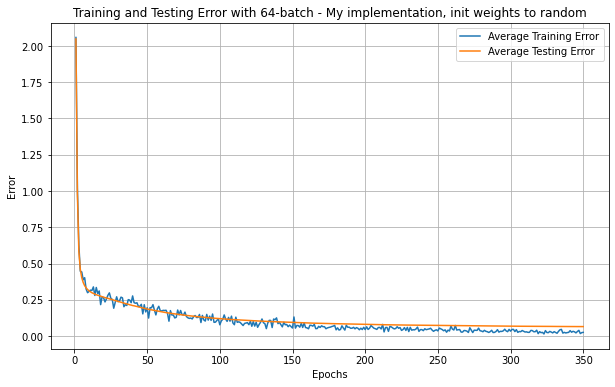

In [256]:
points_per_epoch = num_batches // 100  # Number of times data is appended per epoch
avg_train_e_per_epoch = [np.mean(train_e[i * points_per_epoch: (i + 1) * points_per_epoch]) for i in range(epochs)]
avg_test_e_per_epoch = [np.mean(test_e[i * points_per_epoch: (i + 1) * points_per_epoch]) for i in range(epochs)]

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, avg_train_e_per_epoch, label='Average Training Error')
plt.plot(epochs_range, avg_test_e_per_epoch, label='Average Testing Error')
plt.title('Training and Testing Error with 64-batch - My implementation, init weights to random')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()



Finding overall test error

In [255]:
# Forward pass for entire test set
htest = first_Layer(x_test, model.W_1)
yhatstest = softmax(htest, model.W_2)

# Cross-entropy error computation
epsilon = 1e-10
cross_loss_test = -np.sum(y_test * np.log(yhatstest + epsilon), axis=1)
total_error = np.sum(cross_loss_test)

# Compute number of correct predictions
correct_predictions = np.sum(np.argmax(yhatstest, axis=1) == np.argmax(y_test, axis=1))

# Average error and accuracy
average_error = total_error / len(x_test)
accuracy = (correct_predictions / len(x_test)) * 100

print(f"Total Error on Test: {total_error}")
print(f"Average Error on Test: {average_error}")
print(f"Accuracy on Test: {accuracy:.2f}%")

Total Error on Test: 635.1603399691743
Average Error on Test: 0.06351603399691742
Accuracy on Test: 98.03%


Implementing PyTorch now

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NN, self).__init__()
        ### Implementing the same architecture as I used for my from-scratch model
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.sigmoid(x)
        x = self.layer2(x)
        return x

In [ ]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_labels = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)  # Convert one-hot to class indices
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_labels = torch.tensor(np.argmax(y_test, axis=1), dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_labels)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_labels)

### Using the same batch size as I used previously
batch_size = 32

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)


In [260]:
d1_pt = 300
output = 10
d_pt = 28 * 28
lr = 0.0003
model = NN(d_pt, d1_pt, output)

### Part 4 problem 4 a)
# with torch.no_grad():
#     model.layer1.weight.fill_(0.0)
#     model.layer1.bias.fill_(0.0)
#     model.layer2.weight.fill_(0.0)
#     model.layer2.bias.fill_(0.0)

# Part 4 problem 4 b)
# with torch.no_grad():
#     model.layer1.weight.uniform_(-1, 1)
#     model.layer1.bias.uniform_(-1, 1)
#     model.layer2.weight.uniform_(-1, 1)
#     model.layer2.bias.uniform_(-1, 1)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
epochs = 35


In [261]:
train_losses = []
test_losses = []

for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):   # Iterate over batches
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            test_loss += loss.item()
    
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Epoch 1/35, Training Loss: 0.6114, Test Loss: 0.2995
Epoch 2/35, Training Loss: 0.2739, Test Loss: 0.2381
Epoch 3/35, Training Loss: 0.2218, Test Loss: 0.2057
Epoch 4/35, Training Loss: 0.1874, Test Loss: 0.1783
Epoch 5/35, Training Loss: 0.1613, Test Loss: 0.1534
Epoch 6/35, Training Loss: 0.1405, Test Loss: 0.1394
Epoch 7/35, Training Loss: 0.1234, Test Loss: 0.1247
Epoch 8/35, Training Loss: 0.1094, Test Loss: 0.1157
Epoch 9/35, Training Loss: 0.0971, Test Loss: 0.1066
Epoch 10/35, Training Loss: 0.0871, Test Loss: 0.1023
Epoch 11/35, Training Loss: 0.0782, Test Loss: 0.0946
Epoch 12/35, Training Loss: 0.0706, Test Loss: 0.0887
Epoch 13/35, Training Loss: 0.0636, Test Loss: 0.0854
Epoch 14/35, Training Loss: 0.0576, Test Loss: 0.0828
Epoch 15/35, Training Loss: 0.0522, Test Loss: 0.0789
Epoch 16/35, Training Loss: 0.0473, Test Loss: 0.0772
Epoch 17/35, Training Loss: 0.0433, Test Loss: 0.0733
Epoch 18/35, Training Loss: 0.0391, Test Loss: 0.0698
Epoch 19/35, Training Loss: 0.0356, T

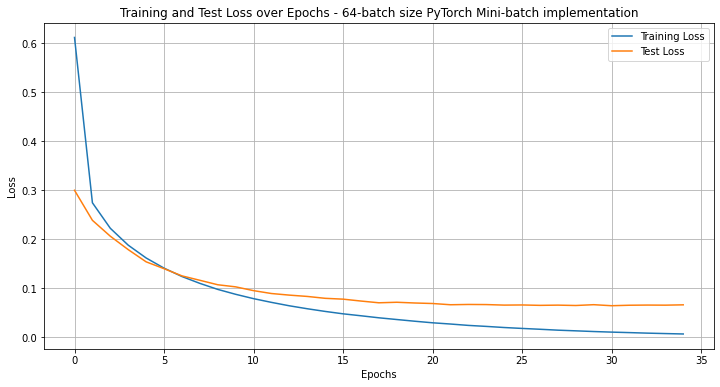

In [262]:
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Test Loss over Epochs - 64-batch size PyTorch Mini-batch implementation")
plt.legend()
plt.grid(True)
plt.show()

In [263]:
correct = 0
N = 0

with torch.no_grad():  
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = outputs.max(1)
        correct += (predicted == target).sum().item()
        N += target.size(0)

accuracy = correct / N * 100

print(f"Total Error on Test Set: {test_losses[-1]:.4f}")
print(f"Total Accuracy on Test Set: {accuracy:.2f}%")

Total Error on Test Set: 0.0656
Total Accuracy on Test Set: 97.91%
